<img style="float: left;" src="images/logo.png" width=200>

# Does Mobility Make or Break Friendships? - Data Analysis
---
## Part 0: Imports and loading


In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pycountry
import reverse_geocode
import pycountry_convert as pc

import requests

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import cosine_similarity

import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import functions as fn

In [2]:
# Data folder and dataset location
DATA_FOLDER = 'data/'
FOURSQUARE_FRIENDSHIP_OLD_DATASET = DATA_FOLDER + "dataset_WWW_friendship_old.txt"
FOURSQUARE_FRIENDSHIP_NEW_DATASET = DATA_FOLDER + "dataset_WWW_friendship_new.txt"
PREPROCESSED_FRIENDSHIP_DATASET = DATA_FOLDER + "friendship_df.csv.zip"
PREPROCESSED_CHECKIN_DATASET = DATA_FOLDER + "checkin_df.csv.zip"
PREPROCESSED_VENUE_DATASET = DATA_FOLDER + "venue_df.csv.zip"

# Read datasets and create dataframes
friendship_old_df = pd.read_csv(FOURSQUARE_FRIENDSHIP_OLD_DATASET, sep='\t', header=None)
friendship_new_df = pd.read_csv(FOURSQUARE_FRIENDSHIP_NEW_DATASET, sep='\t', header=None)
friendship_df = pd.read_csv(PREPROCESSED_FRIENDSHIP_DATASET)
checkin_df = pd.read_csv(PREPROCESSED_CHECKIN_DATASET)
venue_df = pd.read_csv(PREPROCESSED_VENUE_DATASET)

In [3]:
# Convert check-in time to datetime format
checkin_df['checkin_time'] = pd.to_datetime(checkin_df['checkin_time'])

# Add columns to friendship networks
friendship_old_df.columns = ['user_id', 'friendship']
friendship_new_df.columns = ['user_id', 'friendship']

In [4]:
venue_df.level_1_category.nunique()

275

---

## Part 1: Introduction

Our data has been cleaned in the 'preprocessing.ipynb' notebook, now it's time for analysis. We have a two snapshot of Foursquare friendships before and after a 22 month period. Our aim is to create an accurate model that will use a user's mobility to predict how many friendships a they will make over this 22 month period.

First, we will use the same technique as the "Friendship and Mobility" paper. This consists of finding a user's home by dividing the world into 25km x 25km cells, calculating which cell has the most check-ins for each user, and calculating the average position of check-ins within this cell.

First we have to merge the venue information and the check-in information dataframes.

In [5]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_0_category','level_1_category'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,country_code
13932931,162174,4d313b3aeefa8cfab25229b3,2013-01-24 19:06:24,14.531343,121.021373,PH
3367434,846833,4c9b225580958cfa82b248d4,2013-04-12 13:05:24,38.457668,27.226106,TR
11738253,1912591,4f2bab41e4b0f215a4ea6ad4,2012-12-23 10:28:02,49.254154,4.027920,FR


Then we discretise the world into 25km x 25km cells.

In [6]:
# Global variable for cell size
CELL = 25

# Create dataframe
discrete_df = merged_df.copy()

# Calculate index and discrete value of latitude
index_lat = ((90 + discrete_df.latitude)/fn.km_to_lat(CELL)).astype(int)
discrete_lat = index_lat*fn.km_to_lat(CELL)-90

# Calculate index and discrete value of longitude
index_lon = ((180 + discrete_df.longitude)/fn.km_to_lon(discrete_lat, CELL)).astype(int)
discrete_lon = index_lon*fn.km_to_lon(discrete_lat, CELL)-180

# Add columns to dataframe
discrete_df['discrete_latitude'] = discrete_lat
discrete_df['discrete_longitude'] = discrete_lon
discrete_df['position_id'] = index_lat.astype(str) + '-' + index_lon.astype(str)

# Visualise dataframe
discrete_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,country_code,discrete_latitude,discrete_longitude,position_id
11378777,256228,4bd798d335aad13ae95b8ff3,2013-01-22 13:24:21,13.770899,100.540615,TH,13.646815,100.410852,461-1212
10706267,22723,4d4eeeca23a76dcb663b65dc,2013-02-03 20:01:07,41.670411,-0.883048,ES,41.525785,-1.014377,585-596
8730220,800169,4bc2a8e22a89ef3b4b20f488,2012-05-15 09:20:41,-6.895017,107.588017,ID,-7.037582,107.475621,369-1269


Then we find each user's home cell.

In [7]:
# Group by user and position index and count amount of position indexes
home_cell_df = discrete_df.groupby(['user_id','discrete_latitude','discrete_longitude','position_id'],
                                   as_index = False)['latitude'].count()

# Group by user and select max number of position indexes
home_cell_df = home_cell_df.loc[home_cell_df.groupby('user_id')['latitude'].idxmax()]

# Reformat and rename data 
home_cell_df = home_cell_df.drop(['position_id', 'latitude'], axis=1)
home_cell_df.columns = ['user_id','home_cell_latitude','home_cell_longitude']
    
# Visualise dataframe
home_cell_df.sample(3)

,user_id,home_cell_latitude,home_cell_longitude
307418,247863,-33.567569,-70.719443
683893,740585,0.381821,101.269078
495311,471530,3.079786,101.669651


Then we find each user's home.

In [8]:
# Merge checkins dataframe with home cell dataframe
home_df = pd.merge(merged_df, home_cell_df, on='user_id')

# Keep checkins within home cell
home_df = home_df[(home_df['latitude'] >= home_df['home_cell_latitude']) & \
                  (home_df['latitude'] < home_df['home_cell_latitude'] + fn.km_to_lat(CELL))]

home_df = home_df[(home_df['longitude'] >= home_df['home_cell_longitude']) & \
                  (home_df['longitude'] < home_df['home_cell_longitude'] + \
                   fn.km_to_lon(home_df['home_cell_latitude'], CELL))]

# Group by user for mean latitude and longitude
home_df = home_df.groupby('user_id', as_index = False)[['latitude', 'longitude']].mean()

# Rename and Visualize data
home_df.columns = ['user_id', 'home_latitude', 'home_longitude']

# Visualise dataframe
home_df.sample(3)

,user_id,home_latitude,home_longitude
54255,841774,42.662115,21.168318
51997,797981,36.203542,36.158040
70815,1198016,35.709050,139.723665


To plot this information, we want to know which country a home is in. We have the country codes for venue IDs, but not for home locations. To get this information we need to use some reverse geocoding to get a country from coordinates.

In [9]:
# Get country name and country code
home_df['country_code'] = home_df.apply(lambda x: fn.get_country_code(x['home_latitude'],x['home_longitude']), axis=1)
home_df['country'] = home_df.apply(lambda x: fn.get_country_name(x['home_latitude'],x['home_longitude']), axis=1)

# Count homes on rach country
home_count_df = home_df.groupby(['country', 'country_code']).count().reset_index()

# Format dataframe for plotting
home_count_df = home_count_df.drop(['home_latitude', 'home_longitude'], axis = 1)
home_count_df['display'] = home_count_df['country'] + ': ' + home_count_df['user_id'].astype(str)
home_count_df.columns = ['country', 'country_code', 'number_of_homes', 'display']
home_count_df['continent'] = home_count_df.apply(lambda x: fn.get_continent_name(x['country_code']), axis=1)

# Visualise dataframe
home_count_df.sample(3)

,country,country_code,number_of_homes,display,continent
31,Croatia,HRV,37,Croatia: 37,Europe
131,Tunisia,TUN,57,Tunisia: 57,Africa
41,Fiji,FJI,1,Fiji: 1,NaN


We can also compute the number of checkins per country.

In [10]:
# Get checkins per country 
checkin_count_df = merged_df.groupby('country_code').count().reset_index()
checkin_count_df = checkin_count_df.drop(['venue_id', 'checkin_time', 'latitude', 'longitude'], axis=1)
checkin_count_df.columns = ['country_code', 'number_of_checkins']
checkin_count_df['country'] = checkin_count_df.apply(lambda x: fn.alpha2_to_name(x['country_code']), axis=1)
checkin_count_df['country_code'] = checkin_count_df.apply(lambda x: fn.alpha2_to_alpha3(x['country_code']), axis=1)
checkin_count_df['display'] = checkin_count_df['country']+': '+checkin_count_df['number_of_checkins'].astype(str)
checkin_count_df = checkin_count_df.dropna()

# Visualise dataframe
checkin_count_df.sample(3)

,country_code,number_of_checkins,country,display
26,BMU,80,Bermuda,Bermuda: 80
197,SWZ,9,Eswatini,Eswatini: 9
130,MCO,356,Monaco,Monaco: 356


We can merge thesedataframes in one to plot.

In [11]:
temp_df = pd.merge(home_count_df, checkin_count_df, on=['country_code','country'])
temp_df.sample(3)

,country,country_code,number_of_homes,display_x,continent,number_of_checkins,display_y
4,Aruba,ABW,3,Aruba: 3,North America,1023,Aruba: 1023
137,United Kingdom,GBR,1564,United Kingdom: 1564,Europe,301822,United Kingdom: 301822
125,Sweden,SWE,206,Sweden: 206,Europe,41552,Sweden: 41552


In [75]:
# Data
cols_dd = ["number_of_homes", "number_of_checkins"]

# we need to add this to select which trace 
# is going to be visible
visible = np.array(cols_dd)

cscale = ['#003f5c','#1e4365','#32466e','#454a76','#574c7d','#684e82','#7a5087',
          '#8d518b','#9f518e','#b25190','#c3528c','#d15782','#dc5d78','#e6656e',
          '#ef6e63','#f57858','#fa824b','#fd8e3c','#ff9a29','#ffa600']

# define traces and buttons at once
traces = []
buttons = []
for i, value in enumerate(cols_dd):
    if value == 'number_of_homes':
        title = 'Number of homes'
        title_button = 'Homes'
        disp = 'display_x'
    elif value == 'number_of_checkins':
        title = 'Number of checkins'
        title_button = 'Checkins'
        disp = 'display_y'
        
    if i == 0:
        colorbar = dict(title='Number of homes', tickvals = [0, 1, 2, 3, 4], 
                ticktext = ['1', '10', '100', '1000','10000'])
    else:
        colorbar = dict(title='Number of checkins', tickvals = [0, 1, 2, 3, 4, 5, 6], 
                ticktext = ['1', '100', '100', '1000', '10000', '100000', '1000000'])
        
    traces.append(go.Choropleth(
        locations=temp_df['country_code'], # Spatial coordinates
        z=np.log10(temp_df[value]), # Data to be color-coded
        hovertemplate = temp_df[disp],
        colorscale = cscale,
        colorbar = colorbar,
        colorbar_title=title,
        visible= True if value==cols_dd[0] else False))

    buttons.append(dict(label=title_button,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"{title}"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))

#fig.update_geos(projection_type="natural earth")

# This is in order to get the first title displayed correctly
first_title = 'Number of Homes'
fig.update_layout(title=f"{first_title}",title_x=0.52,title_y=0.84)
fig.show()

In [76]:
fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(150, 150, 150, 0.07)'
})

fig.update_layout(
    font_color="#fdb73e"
)

fig.show()

fig.write_html("homes_and_checkins_plot.html")

We can also display a bar chart showing the number of check-ins homes and for the top 20 countries.

In [85]:
temp1 = home_count_df.sort_values(by=['number_of_homes'], ascending=False)
temp1 = temp1.reset_index(drop=True)
temp1 = temp1.head(20)
temp1 = temp1.sort_values(by=['number_of_homes'])

temp2 = checkin_count_df.sort_values(by=['number_of_checkins'], ascending=False)
temp2 = temp2.reset_index(drop=True)
temp2 = temp2.head(20)
temp2 = temp2.sort_values(by=['number_of_checkins'])


fig = make_subplots(rows=1, cols=2, shared_yaxes=True, horizontal_spacing = 0.046)

fig.add_trace(go.Bar(
            x=np.array(temp1.number_of_homes),
            y=np.array(temp1.country_code),
            customdata=np.array(temp1.country),
            orientation='h',
            showlegend=False), 1, 1)

fig.add_trace(go.Bar(
            x=np.array(temp2.number_of_checkins),
            y=np.array(temp2.country_code),
            customdata = np.array(temp2.country),
            orientation='h',
            showlegend=False), 1, 2)

fig.update_layout(title="Home and check-in numbers for top 20 countries",
                  title_x=0.5,
                  title_y=0.89,
                  xaxis_title="Number of homes",
                  xaxis2_title="Number of check-ins",
                  yaxis_title=" ",
                  plot_bgcolor='#F5F5FF',
                  height=550)

fig.update_traces(textposition='outside',
                  marker_color=cscale,
                  hovertemplate = 'Number: %{x:f}'+'<br>Country: %{customdata}<extra></extra>')

fig.update_xaxes(autorange='reversed', row=1, col=1)
fig.update_yaxes(side='right', row=1, col=1)

fig.show()

In [86]:
fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(150, 150, 150, 0.07)'
})

fig.update_layout(
    font_color="#fdb73e"
)

fig.show()

fig.write_html("top_20_plot.html")

We can plot a nice visualisation of the categories as well. We merge venue information with checkin information and group the number of check-ins by level 0 category to see which categories are the most popular.

In [87]:
# Merge dataframes
merged_df = checkin_df.merge(venue_df, on='venue_id')
# Group values by level_0_category
merged_df_grouped = merged_df.groupby('level_0_category').size().reset_index(name='number_of_checkins')
merged_df_grouped = merged_df_grouped.sort_values(by='number_of_checkins', ascending = False)

# Visualise dataframe
merged_df_grouped

,level_0_category,number_of_checkins
3,Food,3885074
9,Shop & Service,3120378
10,Travel & Transport,2760016
7,Professional & Other Places,2664898
8,Residence,1856524
6,Outdoors & Recreation,1736333
1,College & University,1513662
0,Arts & Entertainment,929240
4,Nightlife Spot,831598
2,Event,8381


Plot check-ins per level 0 category.

In [88]:
# Plot
data = merged_df_grouped

fig = px.bar(data, x='level_0_category', y='number_of_checkins',
             hover_data=['level_0_category', 'number_of_checkins'], color='number_of_checkins',
             labels={'number_of_checkins':'Number of Checkins', 'level_0_category':'Level 0 Category'})

cscale = ['#003f5c', '#31466d', '#534c7b', '#755086', '#98518d', '#bb5090', '#d6597e', '#e9676b', '#f67a55',
          '#fe8f3b', '#ffa600']

cscale.reverse()

fig.update_traces(marker_color=cscale,
                  hovertemplate = 'Category: %{x}'+'<br>Number of checkins: %{y:f}<extra></extra>')

fig.show()

/Users/thomaskimble/opt/anaconda3/lib/python3.8/site-packages/numpy/core/numeric.py:2378: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



In [90]:
fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(50, 50, 0, 0.02)'
})

fig.update_layout(
    font_color="#fdb73e"
)

fig.show()

fig.write_html("category_plot.html")

---
## Part 2: Check-in social scores

We merge the checkin and venue dataframes to get information for each checkin.

In [91]:
# Merge dataframes
checkin_hour_df = pd.merge(checkin_df, venue_df, on='venue_id')
checkin_hour_df = checkin_hour_df.drop(['latitude','longitude','country_code'], axis=1)
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category
17155076,235324,50a94d1f498ea24de19fc4d8,2012-12-09 19:53:10,Church,Professional & Other Places,Spiritual Center
14749263,1067205,4ff32559e4b0cfb36deff32f,2012-07-07 18:52:43,Event Space,Professional & Other Places,Event Space
10900305,453777,4f35ade5e4b0d9574b1f8382,2012-04-23 20:22:53,Burger Joint,Food,Burger Joint


We create a new dataframe assigning coefficients to each level 0 category.

In [92]:
categories = checkin_hour_df.level_0_category.unique()
social_score = [1.5, 1.1, 1.3, 1.3, 1, 1.2, 1.1, 1.4, 1.3, 1.5, 1]
category_social_score_df = pd.DataFrame({'level_0_category':categories, 'level_0_coefficient':social_score})
category_social_score_df

,level_0_category,level_0_coefficient
0,Nightlife Spot,1.5
1,Professional & Other Places,1.1
2,College & University,1.3
3,Food,1.3
4,Shop & Service,1.0
5,Travel & Transport,1.2
6,Residence,1.1
7,Outdoors & Recreation,1.4
8,Arts & Entertainment,1.3
9,Event,1.5


We merge this dataframe with the previous one to get the following.

In [93]:
checkin_hour_df = pd.merge(checkin_hour_df, category_social_score_df, on='level_0_category')
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient
3336595,2126116,4be9228888ed2d7f319fcc1d,2013-03-29 11:01:18,Building,Professional & Other Places,Building,1.1
9108801,1061598,4b7b35dff964a5201e582fe3,2013-08-17 20:24:03,Mall,Shop & Service,Shopping Mall,1.0
8012631,1391320,4f53b5b07b0c446ac402d33d,2012-12-27 21:16:38,Fried Chicken Joint,Food,Fried Chicken Joint,1.3


We floor the check-in time to get the check-in hour.

In [94]:
checkin_hour_df['checkin_hour'] = checkin_hour_df.checkin_time.dt.floor('H').dt.hour
checkin_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour
18021223,815848,4f4431a0e4b0b5bea41fb9a9,2012-07-17 19:47:21,Yoga Studio,Outdoors & Recreation,Athletics & Sports,1.4,19
11941564,407045,51431448e4b0c9f1c1eaca85,2013-12-03 08:32:31,Market,Shop & Service,Market,1.0,8
2533608,865037,4ca7fad8965c9c748f3dc9fa,2013-04-06 18:58:32,Church,Professional & Other Places,Spiritual Center,1.1,18


We find the peak hours for each checkin by computing the number of minimum hours that have a total of 40% of checkins.

In [95]:
level_1_category_df = pd.DataFrame({'level_1_category': checkin_hour_df.level_1_category.unique()})
level_1_category_df['peak_hours'] = np.nan
level_1_category_df['peak_hours'] = level_1_category_df['peak_hours'].astype('object')

for index, row in level_1_category_df.iterrows():   
    # Group by checkin hour for each category
    checkin_count_df = checkin_hour_df[checkin_hour_df.level_1_category==
                                       row['level_1_category']].groupby(checkin_hour_df['checkin_hour']).count()

    # Drop column and reset index for easier handling
    checkin_count_df = checkin_count_df.drop('checkin_hour', axis=1)
    checkin_count_df = checkin_count_df.reset_index()

    # Get peak hours
    arr = np.array(checkin_count_df['user_id'])
    n = fn.smallest_subset_size(arr, 0.4*sum(arr))
    peak_hours = list(checkin_count_df.nlargest(n, 'user_id').checkin_hour.sort_values())
    level_1_category_df.at[index, 'peak_hours'] = peak_hours

# Visualise peak hour dataframe
level_1_category_df.sample(3)

,level_1_category,peak_hours
228,Scenic Lookout,"[13, 14, 15, 16, 17, 18]"
237,Castle,"[12, 14, 15, 18, 19, 21, 22, 23]"
119,Furniture / Home Store,"[14, 15, 16, 17, 18]"


We merge this dataframe with our previous information.

In [96]:
# Merge information
peak_hour_df = pd.merge(checkin_hour_df, level_1_category_df, on='level_1_category')

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours
18063452,987660,4e0b5a63e4cdfb543c638aab,2013-08-19 18:09:02,Outdoors & Recreation,Outdoors & Recreation,Outdoors & Recreation,1.4,18,"[12, 14, 15, 16, 17, 18, 19]"
5155081,1751292,4b83f895f964a520fe1831e3,2012-09-15 16:39:53,Restaurant,Food,Restaurant,1.3,16,"[12, 13, 14, 18, 19, 20]"
9024806,697949,4b9d3eeef964a520d79c36e3,2012-04-08 16:21:36,Grocery Store,Shop & Service,Food & Drink Shop,1.0,16,"[16, 17, 18, 19, 20]"


We check if each checkin is within the peak hours of its level 1 category.

In [97]:
# Is checkin in peak hours?
peak_hour_df['social_visit'] = peak_hour_df.apply(lambda x: x['checkin_hour'] in x['peak_hours'], axis=1)
peak_hour_df['social_visit'] = peak_hour_df['social_visit'].replace({True: 2, False: 1})

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours,social_visit
1620735,1441589,4fb0cd4be4b0664ab85a26dd,2013-04-09 09:15:50,Office,Professional & Other Places,Office,1.1,9,"[8, 9, 10]",2
18726949,1999499,4e0beb04b61c18a1dc1fbb57,2012-04-07 19:59:35,Multiplex,Arts & Entertainment,Movie Theater,1.3,19,"[18, 19, 20, 21]",2
17645074,254411,4ee1c16830f87dc0a63a5542,2013-04-05 21:15:32,Plaza,Outdoors & Recreation,Plaza,1.4,21,"[12, 13, 16, 17, 18, 19]",1


We now give each check-in a social score according to the following formula:

$S = (level \; 0 \; coef)*(social \; visit)$

With $(social \; visit)=1$ if the visit is not within peak hours, and $(social \; visit)=2$ if it is.

In [98]:
# Compute social score
peak_hour_df['social_score'] = peak_hour_df['level_0_coefficient']*peak_hour_df['social_visit']

# Visualise dataframe
peak_hour_df.sample(3)

,user_id,venue_id,checkin_time,category,level_0_category,level_1_category,level_0_coefficient,checkin_hour,peak_hours,social_visit,social_score
5110694,1717398,4b88f421f964a5201a1532e3,2012-07-28 17:57:35,American Restaurant,Food,American Restaurant,1.3,17,"[12, 13, 18, 19, 20]",1,1.3
17891644,96678,4f03093fd3e364d5ff5cf507,2013-02-02 17:20:03,Park,Outdoors & Recreation,Park,1.4,17,"[14, 15, 16, 17, 18, 19]",2,2.8
2554622,886747,4c92d5ce966eb7139dd18232,2012-07-13 18:17:08,Government Building,Professional & Other Places,Government Building,1.1,18,"[8, 9, 10, 11, 13]",1,1.1


From this we create a new dataframe with the social score for each user. The user social score is the mean of all of their check-in social scores.

In [99]:
# Compute user social score
user_social_score_df = pd.DataFrame(peak_hour_df.groupby('user_id')['social_score'].mean())
user_social_score_df = user_social_score_df.reset_index()

# Visualise dataframe
user_social_score_df.sample(3)

,user_id,social_score
29535,408427,1.686747
54303,842560,1.704407
17084,221057,1.660465


---
## Part 3: Travel score

We want to take a look at the distribution of friends as a function of distance to define a radius that will define whether a user has "travelled" for a check-in. Do do this we use calculate the probability distribution of the distance between a users check-ins and their home.

First we merge all of the venue and check-in information into a single dataframe.

In [100]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_0_category','level_1_category','country_code'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude
12198901,357879,4c56cfb14cc1ef3b5c754b12,2012-10-25 20:20:26,14.551871,121.022118
18653793,207506,503b3985e4b01034f2cf859f,2013-04-30 18:14:01,14.306732,120.901564
3991344,379103,4e6df7588998a706cdb3cd48,2012-04-04 10:52:57,-23.564975,-46.442393


We then compute the distance between each check-in and the users home.

In [101]:
# Create new dataframe with only checkin locations and id
checkins_dist_df = merged_df.copy().drop('checkin_time', axis=1)

# Modify dataframe by merging it with home locations
checkins_dist_df = pd.merge(checkins_dist_df, home_df, on='user_id')

# Drop unnecessary columns
checkins_dist_df = checkins_dist_df.drop(['country_code','country'], axis=1)

# Create a new column with the distance between the checkin and user's home
checkins_dist_df['distance_from_home'] = fn.geo_to_km(checkins_dist_df['latitude'],
                                                      checkins_dist_df['longitude'], 
                                                      checkins_dist_df['home_latitude'], 
                                                      checkins_dist_df['home_longitude'])

# Remove unnecessary columns
checkins_dist_df = checkins_dist_df.drop(['home_latitude', 'home_longitude'], axis=1)

# visualise dataframe
checkins_dist_df.sample(3)

,user_id,venue_id,latitude,longitude,distance_from_home
13688555,1759253,4c362c210a71c9b6f5ad3cc9,38.989237,-77.097733,54.773895
3268320,1238839,4dd1354eae603b786d70d690,40.964782,28.800156,1.895728
17655594,621226,4c158201b7b9c9283621ad37,1.150569,104.331236,1.654506


We remove checkins at home.

In [102]:
checkins_dist_df = checkins_dist_df[checkins_dist_df.distance_from_home != 0]

We plot the distribution.

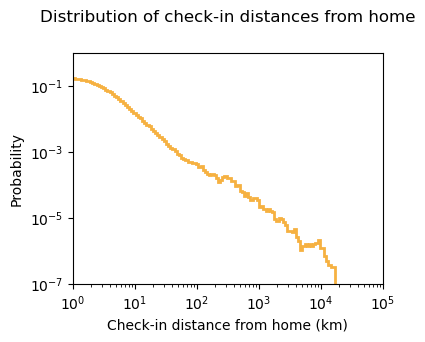

In [103]:
# Change plot style
plt.style.use('default')

# Create linear histogram with linearly spaced bins
_, bins = np.histogram(checkins_dist_df['distance_from_home'], bins=500)

# Create logarithmically spaced bins
logbins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

# Create and plot new histograms with correct bin size
f, ax = plt.subplots(figsize=(4, 3))

n, bins, _ = plt.hist(checkins_dist_df['distance_from_home'], 
                            histtype=u'step', bins=logbins, 
                            density=True, linewidth=2, color='#F6B141')

ax.set(xscale="log", yscale="log")
ax.set_xlim(1,1e5)
ax.set_ylim(1e-7,1)
plt.ylabel('Probability')
plt.xlabel('Check-in distance from home (km)')
_ = plt.title('Distribution of check-in distances from home', y=1.1)

We observe that the distribution follows a power law with a kink in the data at between 70 and 200km from user homes. We Will therefore use the upper value 200km to determine if a user has "traveled" or not for their check-in.

In [104]:
# Get total number of checkins
checkin_count_df = checkins_dist_df.groupby('user_id').count().reset_index()
checkin_count_df = checkin_count_df.drop(['latitude', 'longitude', 'distance_from_home'], axis=1)
checkin_count_df.columns = ['user_id', 'number_of_checkins']

# Get number of "travel" checkins
travel_checkins_dist_df = checkins_dist_df[checkins_dist_df.distance_from_home >= 200]
travel_checkins_dist_df = travel_checkins_dist_df.groupby('user_id').count().reset_index()
travel_checkins_dist_df = travel_checkins_dist_df.drop(['latitude', 'longitude', 'distance_from_home'], axis=1)
travel_checkins_dist_df.columns = ['user_id', 'number_of_travel_checkins_distance']

# Merge dataframes
travel_df = pd.merge(checkin_count_df, travel_checkins_dist_df, on='user_id')

# Fraction of travel checkins (distance)
travel_df['travel_fraction_distance'] = travel_df.number_of_travel_checkins_distance/travel_df.number_of_checkins

# Visualise dataframe
travel_df.sample(3)

,user_id,number_of_checkins,number_of_travel_checkins_distance,travel_fraction_distance
73133,1866488,170,7,0.041176
65266,1479066,102,2,0.019608
25522,419141,83,16,0.192771


We can also use foursquare categories to determine if a user is a traveler or not. Indeed one of the level 0 categories is "Travel & Transport".

In [105]:
# Merge dataframes
merged_df = pd.merge(checkin_df, venue_df, on='venue_id')
merged_df = merged_df.drop(['category','level_1_category','country_code'], axis=1)
merged_df.sample(3)

,user_id,venue_id,checkin_time,latitude,longitude,level_0_category
15339845,1525645,4fd89866e4b000122d87ba62,2012-09-13 18:40:43,39.858262,32.836656,Residence
9084577,96794,4c0ca53f7189c92847cfd5b6,2012-09-15 09:31:03,47.164660,-122.516096,Outdoors & Recreation
4426588,1877228,4bd45e3ea8b3a593a59e6b5f,2013-05-04 22:50:09,38.435422,27.139943,Outdoors & Recreation


In [106]:
# Get "Travel & Transport" category checkins
travel_checkins_category_df = merged_df[merged_df.level_0_category == 'Travel & Transport']
travel_checkins_category_df = travel_checkins_category_df.groupby('user_id').count().reset_index()
travel_checkins_category_df = travel_checkins_category_df.drop(['checkin_time','latitude',
                                                                'longitude','level_0_category'], axis=1)
travel_checkins_category_df.columns = ['user_id', 'number_of_travel_checkins_category']

# Merge with previous dataframe
travel_df = pd.merge(travel_df, travel_checkins_category_df, on='user_id')

# Fraction of travel checkins (category)
travel_df['travel_fraction_category'] = travel_df.number_of_travel_checkins_category/travel_df.number_of_checkins

# Visualise dataframe
travel_df.sample(3)

,user_id,number_of_checkins,number_of_travel_checkins_distance,travel_fraction_distance,number_of_travel_checkins_category,travel_fraction_category
42530,807699,139,1,0.007194,6,0.043165
43897,841967,274,27,0.098540,5,0.018248
30194,522983,321,15,0.046729,47,0.146417


We can plot the mobility of two different type of users differentiated by their travel score. First we create a dataframe with check-in locations and home locations for each user.

In [107]:
# Merge dataframes
home_and_checkins_df = pd.merge(checkin_df, venue_df, on='venue_id')
home_and_checkins_df = home_and_checkins_df.drop(['category','level_0_category',
                                                  'level_1_category','country_code'], axis=1)

# Create new dataframe with only checkin locations and id
home_and_checkins_df = merged_df.copy().drop('checkin_time', axis=1)

# Modify dataframe by merging it with home locations
home_and_checkins_df = pd.merge(home_and_checkins_df, home_df, on='user_id')

# Drop unnecessary columns
home_and_checkins_df = home_and_checkins_df.drop(['country_code','country'], axis=1)

# Visualise
home_and_checkins_df.sample(3)

,user_id,venue_id,latitude,longitude,level_0_category,home_latitude,home_longitude
10031718,365713,4f182bfdc2eec8364b16cdde,-5.105536,-42.761756,Food,-5.090093,-42.781754
4963670,819285,4aad2132f964a520a25e20e3,41.053171,-73.536841,Shop & Service,-7.769998,110.383845
16207299,1803422,511d8f43e4b06599019c825a,2.921879,101.772809,College & University,2.932790,101.767336


We can then plot the mobility of different type of users according to their travel scores (distance).

In [111]:
fig = go.Figure()

colors = ['#c3528c', '#c3528c', '#c3528c',
          '#ffa600', '#ffa600', '#ffa600']

users_low = np.array(user_score_df[user_score_df.travel_score_distance<0.3].user_id.sample(3))
users_high = np.array(user_score_df[user_score_df.travel_score_distance>0.6].user_id.sample(3))
users = np.concatenate((users_low, users_high))

for i,u in enumerate(users):
    df = home_and_checkins_df[home_and_checkins_df.user_id == u]
    
    fig.add_trace(go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        hoverinfo = None,
        mode = 'markers',
        marker = dict(
            size = 3,
            color = colors[i],
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    fig.add_trace(go.Scattergeo(
        lon = df.head(1)['home_longitude'],
        lat = df.head(1)['home_latitude'],
        hoverinfo = None,
        mode = 'markers',
        marker = dict(
            size = 13,
            color = colors[i],
            line = dict(
                width = 3,
                color = 'rgba(68, 68, 68, 0)'
            )
        )))

    lons = []
    lats = []
    lons = np.empty(3 * len(df))
    lons[::3] = df['home_longitude']
    lons[1::3] = df['longitude']
    lons[2::3] = None
    lats = np.empty(3 * len(df))
    lats[::3] = df['home_latitude']
    lats[1::3] = df['latitude']
    lats[2::3] = None

    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            lon = lons,
            lat = lats,
            mode = 'lines',
            line = dict(width = 2,color = colors[i]),
            opacity = 0.8
        )
    )

fig.update_layout(
    title={
        'text': 'User mobility for high (orange) and low (purple) travel scores',
        'y':0.85,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    showlegend = False,
    geo = go.layout.Geo(
        #scope = 'north america',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    height=700,
)

fig.show()

We can clearly see that users with a higher travel score tend to have a lot more check-ins abroad, and much further away than none travelers.

In [118]:
fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(50, 50, 0, 0.02)'
})

fig.update_layout(
    font_color="#fdb73e",
    title_y=0.82
)

fig.show()

fig.write_html("travel_plot.html")

---
## Part 4: User scores

We create a dataframe with the three user scores:
* Social Score
* Travel Score (distance)
* Travel Score (category)

In [119]:
# Create user score dataframe
user_score_df = user_social_score_df.copy()

# Remove unnecessary columns
travel_score_df = travel_df.drop(['number_of_checkins', 
                                  'number_of_travel_checkins_distance', 
                                  'number_of_travel_checkins_category'],axis=1)

# Merge dataframes to get user score dataframe
user_score_df = pd.merge(user_score_df, travel_score_df, on='user_id')

# Rename columns
user_score_df.columns = ['user_id', 'social_score', 'travel_score_distance', 'travel_score_category']

# Visualise dataframe
user_score_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
5504,71559,1.568155,0.014881,0.014881
294,4074,1.697260,0.073059,0.050228
9269,125815,1.636471,0.164706,0.117647


We normalise the scores.

In [145]:
# Copy dataframe
user_score_norm_df = user_score_df.copy()

# Normalise scores
user_score_norm_df['social_score'] = (user_score_norm_df.social_score - \
                                      user_score_norm_df.social_score.min()) / \
                                      (user_score_norm_df.social_score.max() - \
                                       user_score_norm_df.social_score.min())

user_score_norm_df['travel_score_distance'] = (user_score_norm_df.travel_score_distance - \
                                               user_score_norm_df.travel_score_distance.min()) / \
                                               (user_score_norm_df.travel_score_distance.max() - \
                                                user_score_norm_df.travel_score_distance.min())

user_score_norm_df['travel_score_category'] = (user_score_norm_df.travel_score_category - \
                                               user_score_norm_df.travel_score_category.min()) / \
                                                (user_score_norm_df.travel_score_category.max() - \
                                                 user_score_norm_df.travel_score_category.min())

user_score_norm_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
71830,1855631,0.205083,0.048233,0.141538
21966,355456,0.454780,0.656332,0.395536
8147,108888,0.310841,0.045374,0.006697


In [146]:
#Create dataframe
user_score_home_df = pd.merge(user_score_norm_df, home_df[['user_id','country','country_code']], on='user_id')

# Normalise the scores 
user_score_norm_df['display_social'] = user_score_home_df['country'] + ': ' + \
                                          round(user_score_home_df['social_score'],4).astype(str)

user_score_norm_df['display_travel_distance'] = user_score_home_df['country'] + ': ' + \
                                                   round(user_score_home_df['travel_score_distance'],4).astype(str)

user_score_norm_df['display_travel_category'] = user_score_home_df['country'] + ': ' + \
                                                   round(user_score_home_df['travel_score_category'],4).astype(str)

We merge with the home location dataframe, groupby the country and calculate the mean of each score per country.

In [147]:
# Merge dataframes
user_score_home_df = pd.merge(user_score_norm_df, home_df, on='user_id')
user_score_home_df = user_score_home_df.drop(['home_latitude', 'home_longitude'], axis=1)

# Grouby country
user_score_country_df = user_score_home_df.groupby(['country_code','country']).mean().reset_index()
user_score_country_df.drop('user_id', axis=1)

# New columns for plot display
user_score_country_df['display_social'] = user_score_country_df['country'] + ': ' + \
                                          round(user_score_country_df['social_score'],4).astype(str)
user_score_country_df['display_travel_distance'] = user_score_country_df['country'] + ': ' + \
                                                   round(user_score_country_df['travel_score_distance'],4).astype(str)
user_score_country_df['display_travel_category'] = user_score_country_df['country'] + ': ' + \
                                                   round(user_score_country_df['travel_score_category'],4).astype(str)

# Visualise the dataframe
user_score_country_df.sample(3)

,country_code,country,user_id,social_score,travel_score_distance,travel_score_category,display_social,display_travel_distance,display_travel_category
55,HKG,Hong Kong,502738.725000,0.481887,0.267480,0.245174,Hong Kong: 0.4819,Hong Kong: 0.2675,Hong Kong: 0.2452
11,BEN,Benin,906955.000000,0.436846,0.360878,0.179421,Benin: 0.4368,Benin: 0.3609,Benin: 0.1794
103,PER,Peru,651418.486316,0.446548,0.101351,0.089503,Peru: 0.4465,Peru: 0.1014,Peru: 0.0895


In [148]:
# Data
cols_dd = ["social_score", "travel_score_distance", "travel_score_category"]
# we need to add this to select which trace 
# is going to be visible
visible = np.array(cols_dd)

cscale = ['#003f5c','#1e4365','#32466e','#454a76','#574c7d','#684e82','#7a5087',
          '#8d518b','#9f518e','#b25190','#c3528c','#d15782','#dc5d78','#e6656e',
          '#ef6e63','#f57858','#fa824b','#fd8e3c','#ff9a29','#ffa600']
# define traces and buttons at once
traces = []
buttons = []
for value in cols_dd:
    if value == 'social_score':
        title = 'Mean Social Score by Country'
        b = 'Social Score'
    elif value == 'travel_score_distance':
        title = 'Mean Travel Score (distance) by Country'
        b = 'Travel Score <br>(distance)'
    elif value == 'travel_score_category':
        title = 'Mean Travel Score (category) by Country'
        b = 'Travel Score <br>(category)'
    traces.append(go.Choropleth(
        locations=user_score_country_df['country_code'], # Spatial coordinates
        z=user_score_country_df[value].astype(float), # Data to be color-coded
        colorscale = cscale,
        colorbar_title='Score',
        visible= True if value==cols_dd[0] else False))

    buttons.append(dict(label=b,
                        method="update",
                        args=[{"visible":list(visible==value)},
                              {"title":f"{title}"}]))

updatemenus = [{"active":0,
                "buttons":buttons,
               }]


# Show figure
fig = go.Figure(data=traces,
                layout=dict(updatemenus=updatemenus))

fig.update_geos(projection_type="natural earth")

fig.update_traces(hovertemplate = 'Score: %{z}<extra></extra>')

# This is in order to get the first title displayed correctly
first_title = 'Mean Social Score by Country'
fig.update_layout(title=f"{first_title}",title_x=0.54,title_y=0.87)
fig.show()

---
## Part 5: Cosine Similarity


In [153]:
# Copy dataframes
df_checkins_cleaned = checkin_df.copy()
df_friendships_cleaned = friendship_df.copy()
df_venues_cleaned = venue_df.copy()

First we want to compute the evolution of a user's friendships: $\frac{n_{friends}(after) - n_{friends}(before)}{n_{friends}(before)}$

In [154]:
# Compute friendship evolution
df_friendships_cleaned['friends_evolution'] = (df_friendships_cleaned['num_friends_after'] - \
                                               df_friendships_cleaned['num_friends_before']) / \
                                                df_friendships_cleaned['num_friends_before']

# Visualise dataframe
df_friendships_cleaned.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,friends_evolution
17806,248930,1,1,0,0.0
65223,1400490,1,1,0,0.0
19209,273168,2,1,-1,-0.5


We can now merge the checkins dataframe with the venues dataframe, group by the level 1 category and calculate the scaled frequency at which each user visits each venue within a level 1 category. After this we split the data into training (80%) and testing (20%) sets.

In [155]:
# Merge dataframes
df_merged = df_checkins_cleaned.merge(df_venues_cleaned, how='left', on='venue_id')
df_merged = df_merged[df_merged.user_id.isin(df_friendships_cleaned.user_id)]

# Groupby level 1 category
df_final = df_merged.groupby(['user_id', 'level_1_category']).size().reset_index(name='frequency')

# Get checkins in category
nbr_checkins = df_merged.groupby('user_id').size().reset_index(name='number_of_checkins')

# Create scaled frequency dataframe
df_final = df_final.merge(nbr_checkins, on='user_id', how='left')
df_final['adj_frequency'] = df_final['frequency'] / df_final['number_of_checkins'] * 1.0
df_final = df_final.pivot(index='user_id', columns='level_1_category', values='adj_frequency').fillna(0)
df_final.head()

# Split data
train, test = train_test_split(df_final, train_size=0.8)

In [156]:
# Visualise dataframe
df_final.sample(3)

level_1_category,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,...,Video Game Store,Video Store,Vineyard,Volcano,Voting Booth,Water Park,Well,Winery,Wings Joint,Zoo
user_id,,,,,,,,,,,,,,,,,,,,,
770954,0.0,0.0,0.0,0.037037,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.009259,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1107209,0.0,0.0,0.0,0.082353,0.011765,0.0,0.0,0.011765,0.0,0.0,...,0.0,0.011765,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
251643,0.0,0.0,0.0,0.121795,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We want to find 5 users in the training set that are the most similar to a particular user in the testing set according to the check-ins they have made.

In [157]:
# Get scores from cosine similarity
sim_scores = cosine_similarity(test, train)

# Sort similarity scores
sorted_sim = np.argsort(sim_scores, axis=1)
sorted_sim = sorted_sim[:, -6:-1]

We get the 5 similar user's id value.

In [158]:
user_IDs = train.index.values
venue_IDs = list(train.columns.values)

top_n_idx = []
top_n_userIDs = []
top_n_scores = []
top_n_new_friendships = []

for i in range(len(sorted_sim)):
    top_n_idx.append(sorted_sim[i])
    top_n_userIDs.append(user_IDs.take(sorted_sim[i])) #Inefficient
    top_n_scores.append(sim_scores[i].take(sorted_sim[i]))

top_n_idx = np.array(top_n_idx)
top_n_userIDs = np.array(top_n_userIDs)
top_n_scores = np.array(top_n_scores)

We create a datframe with the sorted 5 most similar user's to each individual user.

In [160]:
# Create and format dataframe
sorted_df_with_user_ids = pd.DataFrame(top_n_userIDs)
sorted_df_with_user_ids.index = test.index
sorted_df_with_user_ids.columns = ['most_similar', 'second', 'third', 'fourth', 'fifth']

# Visualise dataframe
sorted_df_with_user_ids.sample(3)

,most_similar,second,third,fourth,fifth
user_id,,,,,
284721,559833,1614543,1158483,752445,969862
572909,372892,341110,348352,898422,756004
16470,500622,1908874,1397649,463496,1090002


We determine how the number of friends of these users changed over the data collection period.

In [161]:
# Replace user id values by the friendship evolution value.
sorted_new = sorted_df_with_user_ids.copy()

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='most_similar', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['most_similar'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='second',
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['second'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='third', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['third'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='fourth', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['fourth'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new = sorted_new.merge(df_friendships_cleaned, left_on='fifth', 
                                     right_on='user_id', how='left')[['most_similar','second',
                                                                      'third','fourth','fifth',
                                                                      'friends_evolution']]
sorted_new['fifth'] = sorted_new['friends_evolution']
sorted_new = sorted_new.drop(columns='friends_evolution')
sorted_new.index = sorted_df_with_user_ids.index

sorted_new.sample(3)

,most_similar,second,third,fourth,fifth
user_id,,,,,
324308,-0.333333,0.666667,1.666667,0.0,3.000000
736776,0.000000,2.000000,-0.333333,0.0,0.571429
942984,0.000000,3.000000,1.500000,1.0,0.454545


We compute the estimated variation of the number of friends of the users in the test set.

In [162]:
# Predict evolution
sorted_new['predicted_friends_evolution'] = ((16*sorted_new['most_similar'] + \
                                              8*sorted_new['second'] + \
                                              4*sorted_new['third'] + \
                                              2*sorted_new['fourth'] + \
                                              1*sorted_new['fifth']) / 31)

# Visualise dataframe
sorted_new.head()

,most_similar,second,third,fourth,fifth,predicted_friends_evolution
user_id,,,,,,
731816,0.333333,3.000000,2.0,0.000000,-0.333333,1.193548
34646,2.000000,0.000000,0.0,0.500000,0.500000,1.080645
965205,1.500000,2.333333,0.5,0.000000,6.000000,1.634409
426523,0.666667,0.000000,0.0,0.333333,0.000000,0.365591
111445,-0.555556,-0.500000,0.0,1.333333,2.222222,-0.258065


We merge with the friendship dataframe and convert the evolution in to the number of friends gained.

In [163]:
# Merge dataframes
sorted_new = sorted_new.merge(df_friendships_cleaned, on='user_id')

# Compute friend gain
sorted_new['predicted_friends_gained'] = np.round(sorted_new.predicted_friends_evolution * \
                                                  (1+sorted_new.num_friends_before))

# Visualise dataframe
sorted_new.sample(3)

,user_id,most_similar,second,third,fourth,fifth,predicted_friends_evolution,num_friends_before,num_friends_after,num_friends_gained,friends_evolution,predicted_friends_gained
981,144388,0.0,0.0,13.00,0.571429,0.5,1.730415,1,2,1,1.0,3.0
7968,509001,2.0,9.0,-0.50,0.000000,1.5,3.338710,6,12,6,1.0,23.0
139,138785,0.0,1.0,0.25,2.666667,-0.2,0.455914,3,3,0,0.0,2.0


We plot the histogram of residuals.

Text(0, 0.5, 'Probability')

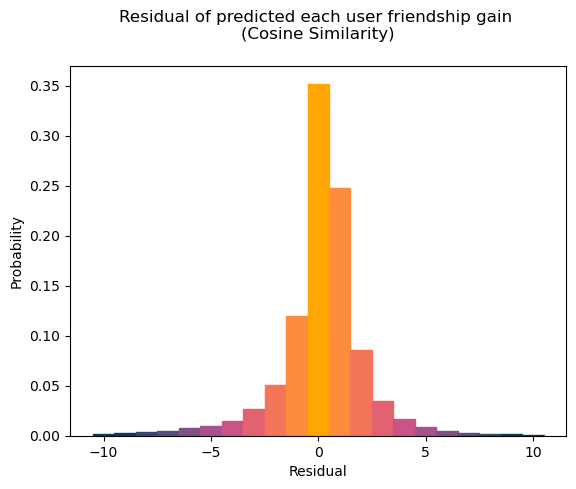

In [179]:
colors = ['#003f5c', '#003f5c', '#35476f', '#5b4d7e', '#805089', 
          '#a7518f', '#cb5486', '#e36271', '#f4755a', '#fd8c3e', 
          '#ffa600', '#fd8c3e', '#f4755a', '#e36271', '#cb5486', 
          '#a7518f', '#805089', '#5b4d7e', '#35476f', '#003f5c', '#003f5c']

residual = sorted_new.predicted_friends_evolution - sorted_new.friends_evolution
N, bins, patches = plt.hist(residual, bins=np.linspace(-10.5, 10.5, 22), density=True)

for i in range(len(patches)):
    patches[i].set_color(colors[i])

plt.title('Residual of predicted each user friendship gain \n(Cosine Similarity)', y=1.05)
plt.xlabel("Residual")
plt.ylabel("Probability")

In [320]:
df = pd.DataFrame(residual)
df.columns = ['residual']
df = round(df)

In [321]:
cscale = ['#003f5c', '#003f5c', '#003f5c', '#35476f', '#5b4d7e', '#805089', 
          '#a7518f', '#cb5486', '#e36271', '#f4755a', '#fd8c3e', 
          '#ffa600', '#fd8c3e', '#f4755a', '#e36271', '#cb5486', 
          '#a7518f', '#805089', '#5b4d7e', '#35476f', '#003f5c', '#003f5c', '#003f5c']

for i in range(221):
    cscale.append('#fd8c3e')
    
cscale.reverse()

fig = px.histogram(df,x='residual', nbins=500, range_x=[-11, 11], histnorm='probability density')

fig.update_traces(marker_color=cscale)

fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(50, 50, 0, 0.02)'
})

fig.update_layout(
    font_color="#fdb73e",
    title='Residual of predicted each user friendship gain <br> (Cosine Similarity)',
    title_x=0.5
)

fig.show()

fig.write_html("cosine_model.html")

---
## Part 6: Regression models


In [165]:
friendship_df['variation'] = (friendship_df.num_friends_after-friendship_df.num_friends_before)/ \
                                friendship_df.num_friends_before

In [166]:
friendship_df.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,variation
10265,125142,89,15,-74,-0.831461
59379,1144536,14,19,5,0.357143
48073,829879,4,2,-2,-0.500000


In [167]:
user_score_df['social_score'] = (user_score_df.social_score-user_score_df.social_score.min())/ \
                                (user_score_df.social_score.max()-user_score_df.social_score.min())

user_score_df['travel_score_distance'] = (user_score_df.travel_score_distance-user_score_df.travel_score_distance.min())/ \
                                       (user_score_df.travel_score_distance.max()-user_score_df.travel_score_distance.min())

user_score_df['travel_score_category'] = (user_score_df.travel_score_category-user_score_df.travel_score_category.min())/ \
                                       (user_score_df.travel_score_category.max()-user_score_df.travel_score_category.min())

user_score_df.sample(3)

,user_id,social_score,travel_score_distance,travel_score_category
59120,1288237,0.425096,0.001006,0.278738
50221,1009983,0.380003,0.203412,0.122074
40959,770423,0.506465,0.062200,0.121368


In [168]:
merged_df = pd.merge(friendship_df, user_score_df, on='user_id')

merged_df.sample(3)

,user_id,num_friends_before,num_friends_after,num_friends_gained,variation,social_score,travel_score_distance,travel_score_category
29334,562214,1,4,3,3.0,0.390480,0.030226,0.015844
56365,1811191,1,2,1,1.0,0.434989,0.022671,0.111677
35498,729114,4,6,2,0.5,0.532846,0.024816,0.068894


In [302]:
train_df, test_df = train_test_split(merged_df, train_size=0.8)

features = ['social_score','travel_score_distance','travel_score_category']
features = ['travel_score_distance','travel_score_category']
label = 'variation'

X_train = train_df[features]
y_train = train_df[label]
X_test = test_df[features]
y_test = test_df[label]

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

predicted_variation = lin_reg.predict(X_test)

model_df = test_df.copy()
model_df['predicted_gain'] = (1-predicted_variation)*model_df.num_friends_before
model_df['residual'] = model_df.predicted_gain-model_df.num_friends_gained

Text(0, 0.5, 'Probability')

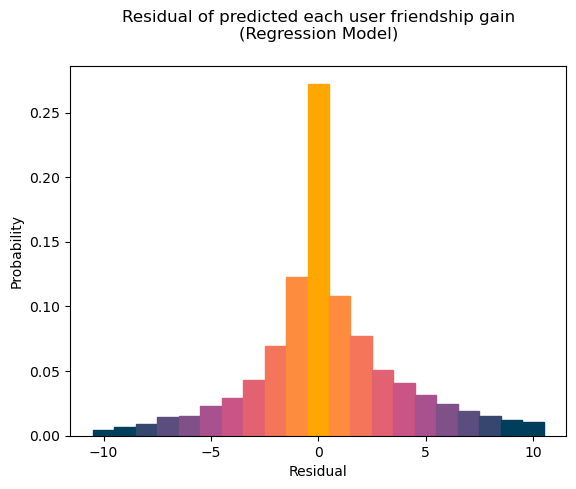

In [303]:
N, bins, patches = plt.hist(model_df.residual, bins=np.linspace(-10.5, 10.5, 22), density=True)

for i in range(len(patches)):
    patches[i].set_color(colors[i])
    
plt.title('Residual of predicted each user friendship gain\n(Regression Model)', y=1.05)
plt.xlabel("Residual")
plt.ylabel("Probability")


In [322]:
df = model_df.residual
df.columns = ['residual']
df = round(df)

In [323]:
cscale = ['#003f5c', '#003f5c', '#003f5c', '#35476f', '#5b4d7e', '#805089', 
          '#a7518f', '#cb5486', '#e36271', '#f4755a', '#fd8c3e', 
          '#ffa600', '#fd8c3e', '#f4755a', '#e36271', '#cb5486', 
          '#a7518f', '#805089', '#5b4d7e', '#35476f', '#003f5c', '#003f5c', '#003f5c']

for i in range(212):
    cscale.append('#fd8c3e')
    
cscale.reverse()

fig = px.histogram(df, x='residual', nbins=800, range_x=[-11, 11], histnorm='probability density')

fig.update_traces(marker_color=cscale)

fig.update_layout({
    'paper_bgcolor': 'rgba(0, 0, 0, 0)',
    'plot_bgcolor': 'rgba(50, 50, 0, 0.02)'
})

fig.update_layout(
    font_color="#fdb73e",
    title='Residual of predicted each user friendship gain <br> (Regression)',
    title_x=0.5
)

fig.show()

fig.write_html("regression_model.html")

---